In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gcimpute.gaussian_copula import GaussianCopula
from gcimpute.low_rank_gaussian_copula import LowRankGaussianCopula
from gcimpute.helper_data import generate_sigma, generate_mixed_from_gc, generate_LRGC
from gcimpute.helper_evaluation import get_rmse, get_mae, error_by_reliability
from gcimpute.helper_mask import mask_MCAR

## Confidence interval under full rank Gaussian copula model

We use a 2000*15 dimensional dataset generated from the Gaussian copula model whose marginals are exponential distribution with rate parameter 1/3. The coverage results are robust to different marginal distribution specification.

In [3]:
seed = 101
var_types = {'cont':list(range(15)), 'ord':[], 'bin':[]}
n = 2000

In [4]:
sigma = generate_sigma(seed, p=15)
X = generate_mixed_from_gc(sigma=sigma, n=n, seed=seed, var_types=var_types)
X_masked = mask_MCAR(X, mask_fraction=0.4, seed=seed)

In [5]:
model = GaussianCopula(verbose=1)

In [6]:
Ximp = model.fit_transform(X=X_masked)

Iteration 1: copula parameter change 0.1500, likelihood -16.9265
Iteration 2: copula parameter change 0.0722, likelihood -16.6339
Iteration 3: copula parameter change 0.0378, likelihood -16.4543
Iteration 4: copula parameter change 0.0226, likelihood -16.3349
Iteration 5: copula parameter change 0.0149, likelihood -16.2511
Iteration 6: copula parameter change 0.0104, likelihood -16.1903
Iteration 7: copula parameter change 0.0076, likelihood -16.1449
Convergence achieved at iteration 7


In [7]:
get_rmse(x_imp = Ximp, x_true = X, x_obs = X_masked, relative = True)

0.49098554381554577

In [8]:
cover_rate = {}
for alpha in [0.85, 0.9, 0.95]:
    out_confidence_interval = model.get_imputed_confidence_interval(alpha = alpha)
    missing_loc = np.isnan(X_masked)
    lower, upper = out_confidence_interval['lower'], out_confidence_interval['upper']
    cover = (lower[missing_loc] < X[missing_loc]) & (upper[missing_loc] > X[missing_loc])
    cover_rate[alpha] = np.array(cover).mean()

The returned confidence intervals are slightly higher than the specified coverage rate

In [9]:
for key, val in cover_rate.items():
    print(f'The actual coverage rate is {val:.3f} with specified coverage rate {key:.3f}')

The actual coverage rate is 0.878 with specified coverage rate 0.850
The actual coverage rate is 0.920 with specified coverage rate 0.900
The actual coverage rate is 0.963 with specified coverage rate 0.950


## Reliability for continuous data under full rank Gaussian copula model

In [10]:
reliability = model.get_reliability(Ximp = Ximp)

In [11]:
nrmse_by_reliability = error_by_reliability('NRMSE', reliability, 
                                            xtrue=X, ximp=Ximp)

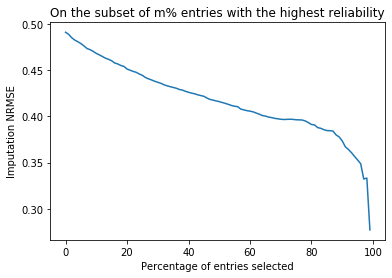

In [12]:
fig,ax = plt.subplots()
ax.plot(nrmse_by_reliability)
_ = ax.set_ylabel('Imputation NRMSE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

## Reliability for ordinal data under full rank Gaussian copula model

### Ordinal variables with ratings 1-5

In [17]:
var_types = {'cont':[], 'ord':list(range(15)), 'bin':[]}

In [18]:
sigma = generate_sigma(seed, p=15)
X = generate_mixed_from_gc(sigma=sigma, n=n, seed=seed, var_types=var_types)
X_masked = mask_MCAR(X, mask_fraction=0.4, seed=seed)

In [19]:
model = GaussianCopula(verbose=1)
Ximp = model.fit_transform(X=X_masked)

Iteration 1: copula parameter change 0.1314, likelihood -16.7013
Iteration 2: copula parameter change 0.0783, likelihood -16.4600
Iteration 3: copula parameter change 0.0456, likelihood -16.2628
Iteration 4: copula parameter change 0.0277, likelihood -16.1185
Iteration 5: copula parameter change 0.0180, likelihood -16.0129
Iteration 6: copula parameter change 0.0124, likelihood -15.9347
Iteration 7: copula parameter change 0.0090, likelihood -15.8757
Convergence achieved at iteration 7


In [20]:
get_mae(x_imp = Ximp, x_true = X, x_obs = X_masked)

0.72325

The default setting of evaluation computes the imputation error in the grid of 100 points. It could happen sometimes the entries with very high reliability (a few top percentiles) are in fact, as shown below.

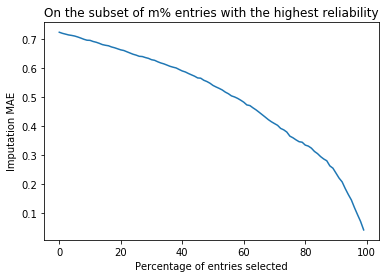

In [21]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=Ximp)

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

### Binary variables

In [24]:
var_types = {'cont':[], 'ord':[], 'bin':list(range(15))}

sigma = generate_sigma(seed, p=15)
X = generate_mixed_from_gc(sigma=sigma, n=n, seed=seed, var_types=var_types)
X_masked = mask_MCAR(X, mask_fraction=0.4, seed=seed)

In [25]:
model = GaussianCopula(verbose=1)
Ximp = model.fit_transform(X=X_masked)

Iteration 1: copula parameter change 0.0556, likelihood -15.9247
Iteration 2: copula parameter change 0.0482, likelihood -15.8873
Iteration 3: copula parameter change 0.0383, likelihood -15.8222
Iteration 4: copula parameter change 0.0292, likelihood -15.7655
Iteration 5: copula parameter change 0.0219, likelihood -15.7184
Iteration 6: copula parameter change 0.0164, likelihood -15.6809
Iteration 7: copula parameter change 0.0123, likelihood -15.6514
Iteration 8: copula parameter change 0.0093, likelihood -15.6285
Convergence achieved at iteration 8


In [26]:
get_mae(x_imp = Ximp, x_true = X, x_obs = X_masked)

0.2519166666666667

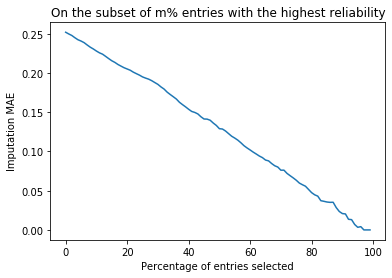

In [27]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=Ximp)

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

## Confidence interval under low rank Gaussian copula model

We use a 500*200 dimensional dataset generated from the low rank Gaussian copula model whose marginals are cubic of standard normals. The coverage results are robust to different marginal distribution specification.

In [28]:
seed = 101
var_types = {'cont':list(range(200)), 'ord':[], 'bin':[]}

In [30]:
X, Wtrue = generate_LRGC(var_types=var_types, 
                             rank=10, sigma=0.1, 
                             n=500, cont_transform=lambda x:x**3,
                             seed=seed)

X_masked = mask_MCAR(X, mask_fraction = 0.4, seed=seed)

In [49]:
model = LowRankGaussianCopula(rank=10, verbose=1)
Ximp = model.fit_transform(X=X_masked)

Interation 1: noise ratio 0.1038, copula parameter change 0.0616, likelihood -131.8197
Interation 2: noise ratio 0.0986, copula parameter change 0.0062, likelihood -127.7395
Convergence achieved at iteration 2


In [50]:
get_rmse(x_imp = Ximp, x_true = X, x_obs = X_masked, relative = True)

0.5401588687548841

In [51]:
cover_rate = {}
for alpha in [0.85, 0.9, 0.95]:
    out_confidence_interval = model.get_imputed_confidence_interval(alpha = alpha)
    missing_loc = np.isnan(X_masked)
    lower, upper = out_confidence_interval['lower'], out_confidence_interval['upper']
    cover = (lower[missing_loc] < X[missing_loc]) & (upper[missing_loc] > X[missing_loc])
    cover_rate[alpha] = np.array(cover).mean()

The returned confidence intervals are slightly lower than the specified coverage rate

In [52]:
for key, val in cover_rate.items():
    print(f'The actual coverage rate is {val:.3f} with specified coverage rate {key:.3f}')

The actual coverage rate is 0.816 with specified coverage rate 0.850
The actual coverage rate is 0.868 with specified coverage rate 0.900
The actual coverage rate is 0.925 with specified coverage rate 0.950


## Reliability for continuous data under low rank Gaussian copula model

In [53]:
reliability = model.get_reliability(Ximp = Ximp)
nrmse_by_reliability = error_by_reliability('NRMSE', reliability, 
                                            xtrue=X, ximp=Ximp)

 It could happen sometimes the entries with very high reliability (a few top percentiles) are in fact bad, as shown below.

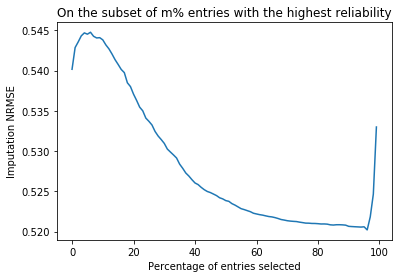

In [54]:
fig,ax = plt.subplots()
ax.plot(nrmse_by_reliability)
_ = ax.set_ylabel('Imputation NRMSE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

If we sample smaller number of points in the grid such that each point is evaluated with more data points, the curve looks good again.

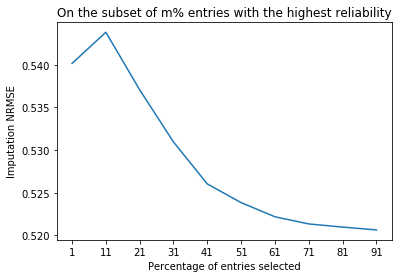

In [56]:
nrmse_by_reliability = error_by_reliability('NRMSE', reliability, 
                                            xtrue=X, ximp=Ximp, num=10)

fig,ax = plt.subplots()
ax.plot(nrmse_by_reliability)
_ = ax.set_ylabel('Imputation NRMSE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')
_ = ax.set_xticks(list(range(10)))
_ = ax.set_xticklabels([str(x+1) for x in range(0, 100, 10)])

## Reliability for ordinal data under low rank Gaussian copula model

### Ordinal variables with ratings 1-5

In [57]:
var_types = {'cont':[], 'ord':list(range(200)), 'bin':[]}

X, Wtrue = generate_LRGC(var_types=var_types, 
                             rank=10, sigma=0.1, 
                             n=500, cont_transform=lambda x:x**3,
                             seed=seed)

X_masked = mask_MCAR(X, mask_fraction = 0.4, seed=seed)

In [58]:
model = LowRankGaussianCopula(rank=10, verbose=1)
Ximp = model.fit_transform(X=X_masked)

Interation 1: noise ratio 0.1602, copula parameter change 0.0477, likelihood -129.4533
Interation 2: noise ratio 0.1430, copula parameter change 0.0206, likelihood -121.0197
Interation 3: noise ratio 0.1316, copula parameter change 0.0108, likelihood -115.2155
Interation 4: noise ratio 0.1236, copula parameter change 0.0066, likelihood -110.9586
Convergence achieved at iteration 4


In [59]:
get_mae(x_imp = Ximp, x_true = X, x_obs = X_masked)

0.239475

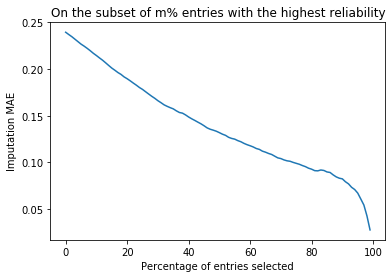

In [60]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=Ximp)

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

### Binary variables

In [61]:
var_types = {'cont':[], 'ord':[], 'bin':list(range(200))}

X, Wtrue = generate_LRGC(var_types=var_types, 
                             rank=10, sigma=0.1, 
                             n=500, cont_transform=lambda x:x**3,
                             seed=seed)

X_masked = mask_MCAR(X, mask_fraction = 0.4, seed=seed)

In [62]:
model = LowRankGaussianCopula(rank=10, verbose=1)
Ximp = model.fit_transform(X=X_masked)

Interation 1: noise ratio 0.2361, copula parameter change 0.0443, likelihood -134.6028
Interation 2: noise ratio 0.2196, copula parameter change 0.0201, likelihood -129.5769
Interation 3: noise ratio 0.2067, copula parameter change 0.0128, likelihood -125.4842
Interation 4: noise ratio 0.1963, copula parameter change 0.0096, likelihood -122.1233
Convergence achieved at iteration 4


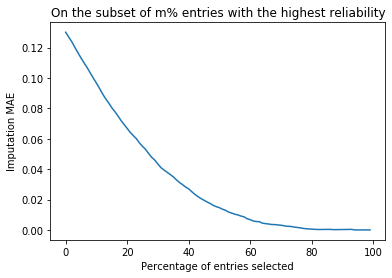

In [63]:
reliability = model.get_reliability()

mae_by_reliability = error_by_reliability('MAE', reliability, 
                                          xtrue=X, ximp=Ximp)

fig,ax = plt.subplots()
ax.plot(mae_by_reliability)
_ = ax.set_ylabel('Imputation MAE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')